In [ ]:
!pip install python_speech_features

In [1]:
!export PATH=/usr/local/cuda-11.8/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH="/usr/local/cuda-11.8/lib64:/usr/local/cuda/extras/CUPTI/lib64"


In [2]:
!echo $LD_LIBRARY_PATH

/usr/local/cuda-11.8/lib64


In [3]:
import os
import librosa
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from python_speech_features import fbank
import pickle
import pandas as pd
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')


2024-08-21 16:07:53.518472: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 16:07:53.518496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 16:07:53.519355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 16:07:53.524229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 16:07:54.183155: W tensorflow/compiler/tf2

Num GPUs Available:  0


2024-08-21 16:07:54.674637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-21 16:07:54.716298: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
directory = '/content/drive/MyDrive/Curruira'

In [4]:
directory="."
print(tf.__version__)

2.15.0


In [6]:
def make_fbank(wav, fs=22050):
    winlen = 512/fs
    winstep = 64/fs
    nfft = 512 # 1024 default
    preemph = 0.5
    mel_filt = 40
    M, _ = fbank(wav, samplerate=fs,
                 nfilt=mel_filt, nfft=nfft,
                 lowfreq=0, highfreq=int(fs/2),
                #  preemph=preemph,
                 winlen=winlen, winstep=winstep,
                 winfunc=lambda x: np.hanning(x) )

    logM = np.log(M)
    logM = np.swapaxes(logM, 0, 1)
    logM = logM[:,:-1] # last window has an artifact

    background = np.float64(logM).mean(axis=1)
    features = np.float32(np.float64(logM) - background[:, np.newaxis])

    targetSize = 682
    while features.shape[1] < targetSize:
        features = np.concatenate((features, features), axis=1)

    if features.shape[1] > targetSize:
        features = features[:,:targetSize]

    # features = features / np.max(np.abs(features))
    return features

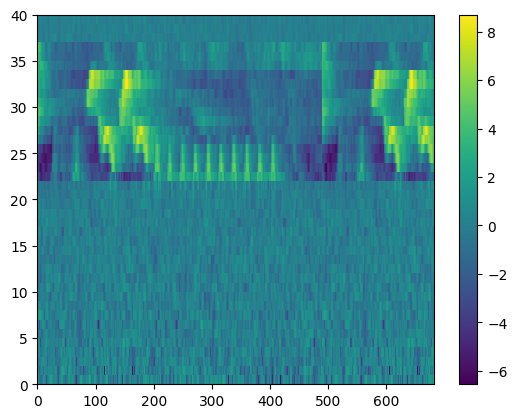

-6.5526056 8.696223


In [7]:
file = os.path.join(directory, 'wav_22k/1-1.wav')
y, sr = librosa.load(file, sr=22050, duration=2) # Downsample 44.1kHz to 22.050kHz
y = (y - np.mean(y))/np.std(y)
# y = librosa.effects.preemphasis(y, coef=0.9)

mel = make_fbank(y, fs=sr)
c = plt.pcolormesh(mel)
plt.colorbar(c)
plt.show()

print(np.min(mel), np.max(mel))

In [8]:
# load csv with labels
df = pd.read_csv(os.path.join(directory,'database.csv'))

# Print the first few rows of the DataFrame
df.head()

,id,classe,dur,aci,csh,th,h,rugo,mean,sd,...,start.DOM,end.DOM,mean.Peakf,mean.Fun,min.Fun,max.Fun,M,NDSI,ZCR,SNR
0,1-1,amostraA,1.443333,181.135349,0.592423,0.934118,0.610518,0.011728,4244.791495,1198.926209,...,4.909570,3.359180,5.763068,4.051095,0.490000,6.3,1.869768e-07,0.999983,0.178520,0.384267
1,1-2,amostraA,1.443333,188.668780,0.576888,0.930290,0.611758,0.011308,4322.532607,1189.521664,...,5.340234,3.445312,5.604785,4.164880,0.648529,6.3,1.846598e-07,0.999985,0.176667,0.391774
2,1-3,amostraA,1.443333,187.586948,0.572755,0.932768,0.610526,0.010834,4277.126276,1154.647335,...,5.254102,4.306641,5.232568,3.836820,0.260947,6.3,1.765932e-07,0.999988,0.173226,0.385895
3,1-4,amostraA,1.443311,192.184149,0.592215,0.931487,0.615280,0.010402,4301.337771,1117.805664,...,4.737305,4.651172,5.627344,4.596743,0.558228,6.3,1.623713e-07,0.999985,0.180283,0.404125
4,1-5,amostraA,1.443333,197.016233,0.570686,0.930845,0.591736,0.009650,4115.425446,1180.996225,...,3.014648,3.445312,5.560352,4.574205,2.004545,14.7,1.547811e-07,0.999973,0.173760,0.324221


In [9]:
def circular_padding(s, fs=22050):

    """Completa o sinal até alcançar os dois segundos"""
    if len(s) >= (2*fs):
        return s[:2*fs]
    else:
        x = np.array([])
        while (len(x) < (2*fs)):
            x = np.append(x,  s)
        return x[:2*fs]

In [10]:
def zero_padding(s, fs=22050):
    """Completa o sinal até alcançar os dois segundos"""
    if len(s) >= (2*fs):
        return s[:2*fs]
    else:
        x = np.array([])
        x = np.append(x,s)
        while (len(x) < (2*fs)):
            x = np.append(x,  0)
        return x[:2*fs]

In [11]:
# folder path
dir_path_in = os.path.join(directory,'wav_22k')

std = []
i = 0
# Iterate directory
for path in tqdm(os.listdir(dir_path_in)):
    # check if current path is a file
    file = os.path.join(dir_path_in, path)
    if os.path.isfile(file):
        y, sr = librosa.load(file, sr=22050, duration=2) # Downsample 44.1kHz to 22.050kHz
        std.append(np.std(y))

std_scale = np.mean(std)
std_scale

  0%|          | 0/889 [00:00<?, ?it/s]

0.07791217

In [12]:
# folder path
dir_path_in = os.path.join(directory,'wav_22k')
global cont
global desvio
global media
desvio = 0
cont = 0
media = 15717.52418447694
mel_spectrograms = []
labels_segments = []
labels_records = []
labels = []
wav_records = []
# avg = []
# std = []
i = 0
# Iterate directory
for path in tqdm(os.listdir(dir_path_in)):
    # check if current path is a file
    file = os.path.join(dir_path_in, path)
    if os.path.isfile(file):
        y, sr = librosa.load(file, sr=22050, duration=2) # Downsample 44.1kHz to 22.050kHz
        # avg.append(np.mean(y))
        # std.append(np.std(y))
        # y = (y - np.mean(y))/np.std(y)
        # y = y + np.random.normal(0, 0.05*np.std(y), len(y)) # augmentation adding 10% of gaussian white noise
        # y = librosa.effects.preemphasis(y, coef=0.9) # causa um efeito estranho no espectrograma MEL
        wav_records.append(circular_padding(y))
        mel_spectrograms.append(make_fbank(y, fs=sr))
        labels_segments.append(path.split('.')[0])
        labels_records.append(path.split('-')[0])
        row = df[df['id'] == path.split('.')[0]]
        label = row.loc[row.index[0], 'classe']
        labels.append(label)

print(cont)
print(len(wav_records))
print((desvio/len(wav_records))**(1/2))

  0%|          | 0/889 [00:00<?, ?it/s]

0
889
0.0


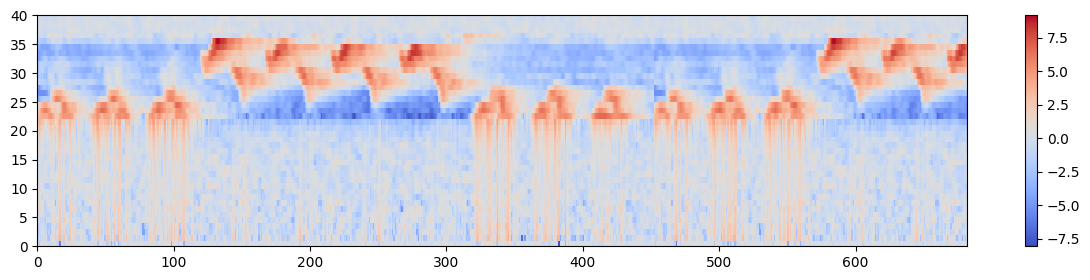

In [13]:
scale = np.max(np.abs(mel_spectrograms))
scale

plt.figure(figsize=(15,3))
plt.pcolormesh(mel_spectrograms[0], cmap='coolwarm')
plt.colorbar()
plt.show()

In [14]:
# folder path
dir_path_in = os.path.join(directory,'Background_noise_22k')

noise_mel_spectrograms = []
noise_labels_segments = []
noise_labels_records = []
noise_labels = []
noise_wav_records = []
mean_std = np.mean(std)

# Iterate directory
for path in tqdm(os.listdir(dir_path_in)):
    # check if current path is a file
    file = os.path.join(dir_path_in, path)
    if os.path.isfile(file):
        y, sr = librosa.load(file, sr=22050, duration=2) # Downsample 44.1kHz to 22.050kHz
        y = (y - np.mean(y))/mean_std
        # y = librosa.effects.preemphasis(y, coef=0.9)
        noise_wav_records.append(zero_padding(y))
        noise_mel_spectrograms.append(make_fbank(y, fs=sr))
        noise_labels_segments.append(path.split('.')[0])
        noise_labels_records.append(path.split('-')[0])
        row = path.split('.')[0]
        label = row[0]
        noise_labels.append(label)

  0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
print(noise_labels)

['A', 'A', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'A', 'A']


In [16]:
print(labels)

['amostraA', 'amostraA', 'amostraA', 'amostraB', 'amostraA', 'amostraB', 'amostraA', 'amostraB', 'amostraB', 'amostraA', 'amostraB', 'amostraA', 'amostraB', 'amostraB', 'amostraB', 'amostraA', 'amostraA', 'amostraB', 'amostraB', 'amostraA', 'amostraA', 'amostraB', 'amostraA', 'amostraA', 'amostraA', 'amostraB', 'amostraB', 'amostraA', 'amostraA', 'amostraB', 'amostraB', 'amostraA', 'amostraA', 'amostraB', 'amostraB', 'amostraB', 'amostraA', 'amostraB', 'amostraB', 'amostraA', 'amostraB', 'amostraB', 'amostraA', 'amostraA', 'amostraA', 'amostraA', 'amostraA', 'amostraB', 'amostraA', 'amostraB', 'amostraA', 'amostraA', 'amostraB', 'amostraA', 'amostraA', 'amostraB', 'amostraA', 'amostraB', 'amostraA', 'amostraB', 'amostraA', 'amostraB', 'amostraA', 'amostraA', 'amostraA', 'amostraA', 'amostraB', 'amostraA', 'amostraB', 'amostraA', 'amostraB', 'amostraB', 'amostraA', 'amostraB', 'amostraB', 'amostraA', 'amostraA', 'amostraA', 'amostraB', 'amostraA', 'amostraB', 'amostraB', 'amostraA', 'am

In [17]:
# Open a file in binary mode and write the pickled list to it
with open(os.path.join(directory,'wav_records.pkl'), 'wb') as f:
    pickle.dump(np.asarray(wav_records), f)

with open(os.path.join(directory,'mel_spectrograms.pkl'), 'wb') as f:
    pickle.dump(np.asarray(mel_spectrograms), f)

with open(os.path.join(directory,'labels_segments.pkl'), 'wb') as f:
    pickle.dump(np.asarray(labels_segments), f)

with open(os.path.join(directory,'labels.pkl'), 'wb') as f:
    pickle.dump(np.asarray(labels), f)

with open(os.path.join(directory,'labels_records.pkl'), 'wb') as f:
    pickle.dump(np.asarray(labels_records), f)

In [18]:
# Open a file in binary mode and write the pickled list to it
with open(os.path.join(directory,'noise_wav_records.pkl'), 'wb') as f:
    pickle.dump(np.asarray(noise_wav_records), f)

with open(os.path.join(directory,'noise_mel_spectrograms.pkl'), 'wb') as f:
    pickle.dump(np.asarray(noise_mel_spectrograms), f)

with open(os.path.join(directory,'noise_labels_segments.pkl'), 'wb') as f:
    pickle.dump(np.asarray(noise_labels_segments), f)

with open(os.path.join(directory,'noise_labels.pkl'), 'wb') as f:
    pickle.dump(np.asarray(noise_labels), f)

with open(os.path.join(directory,'noise_labels_records.pkl'), 'wb') as f:
    pickle.dump(np.asarray(noise_labels_records), f)